In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, cv2, random, json, itertools

from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, 
                                    MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD+
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

Processing style: Graphviz
All categories in Graphviz: ['bin']
No images found in bin category.
Processing style: images
All categories in images: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


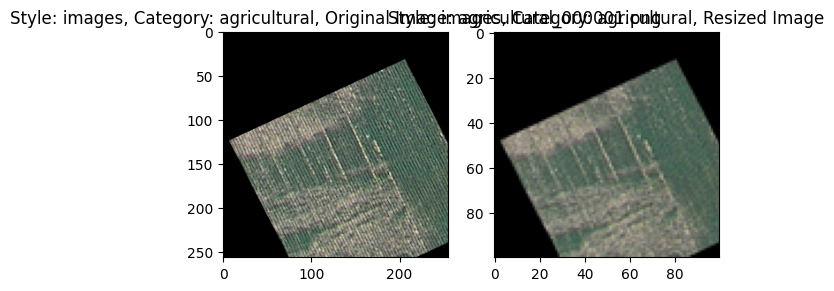

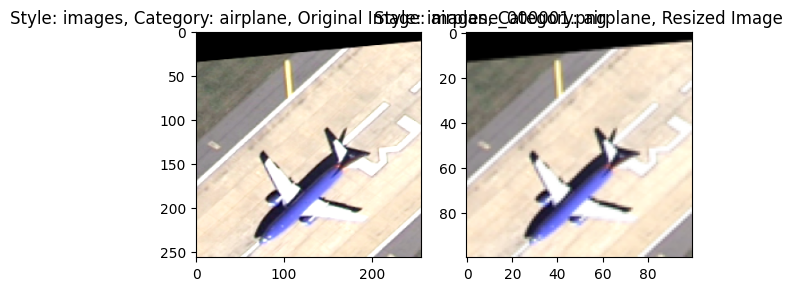

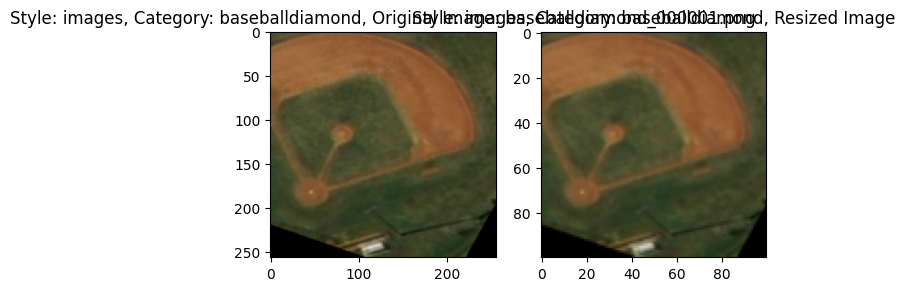

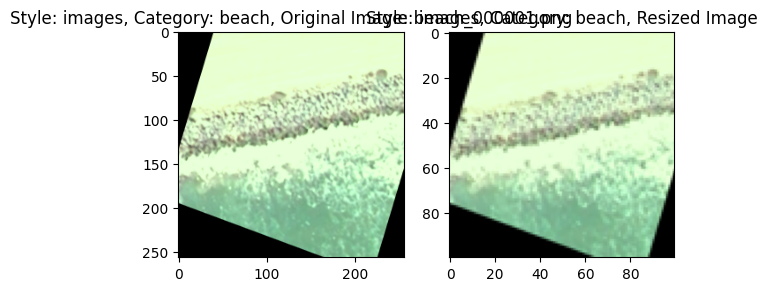

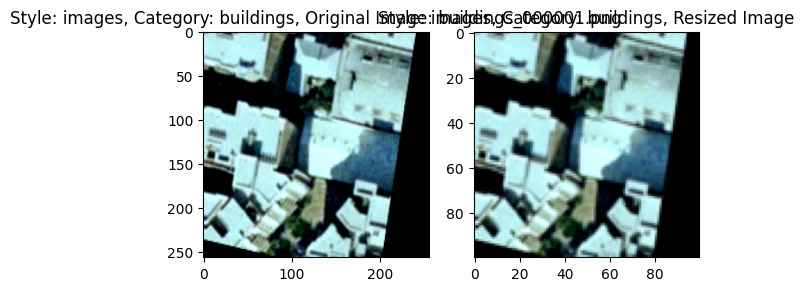

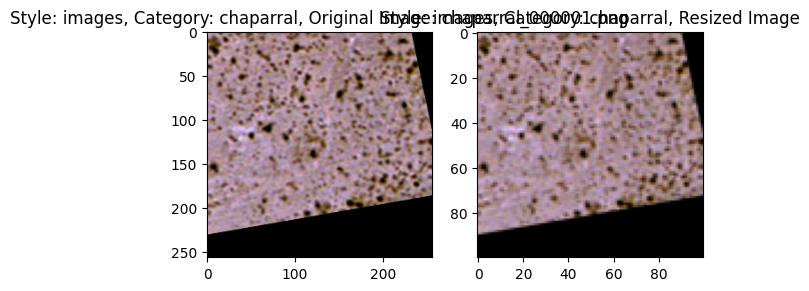

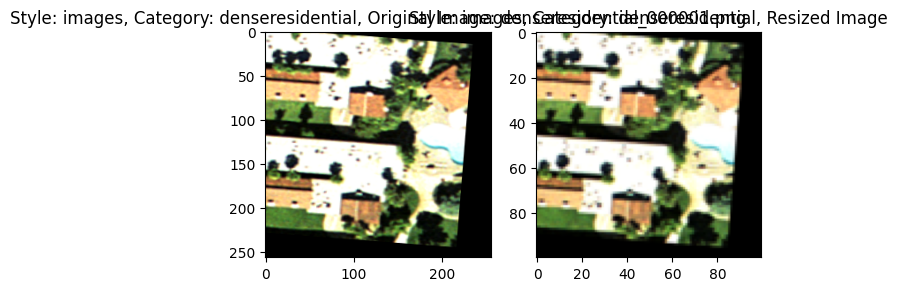

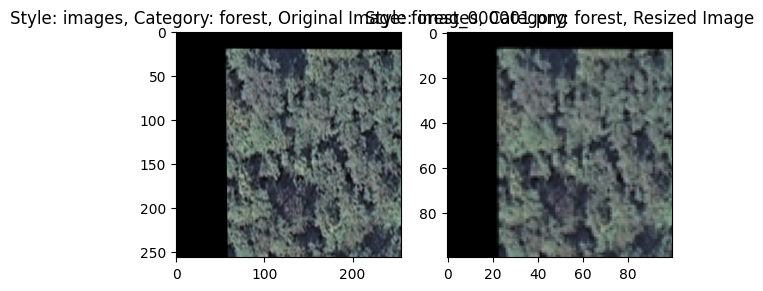

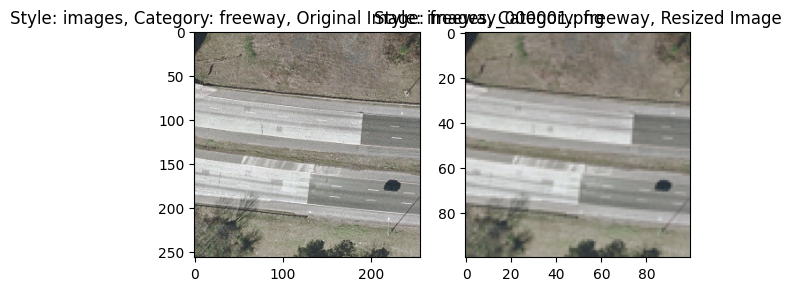

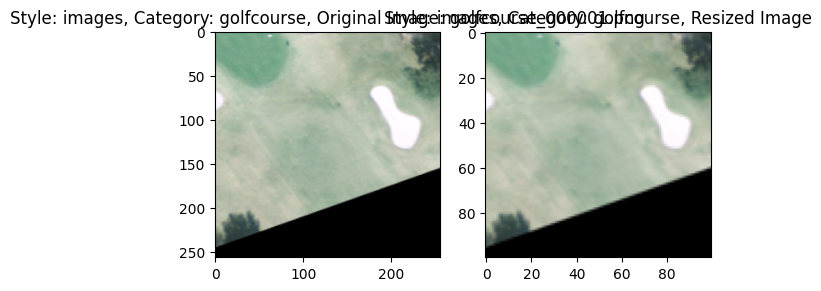

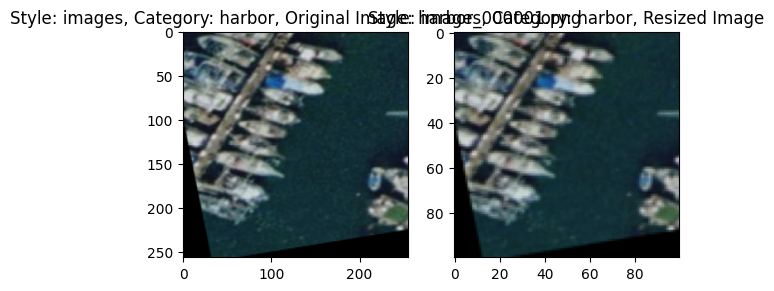

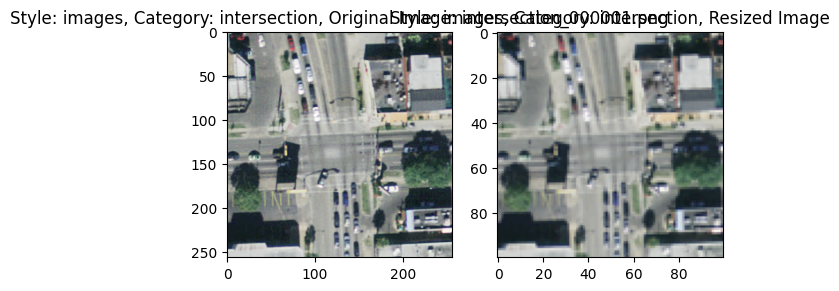

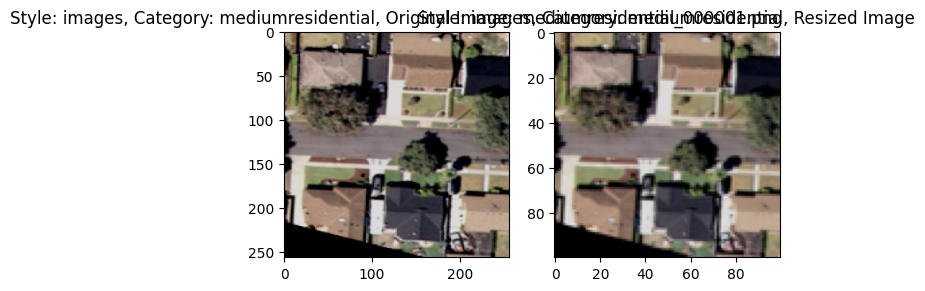

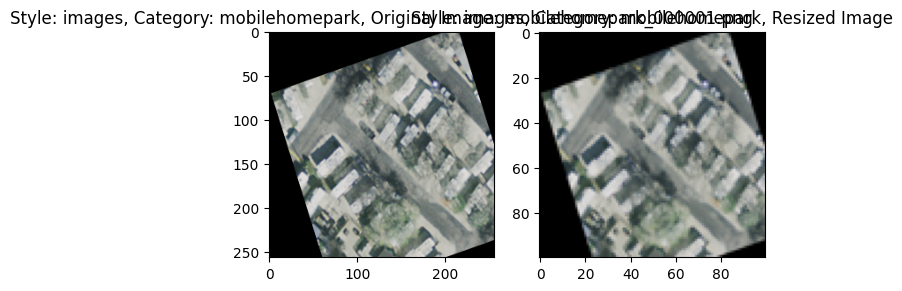

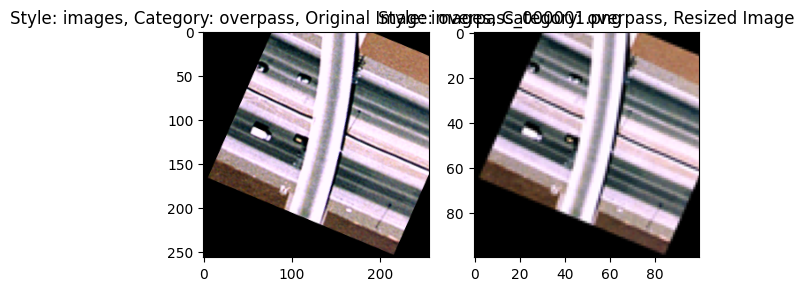

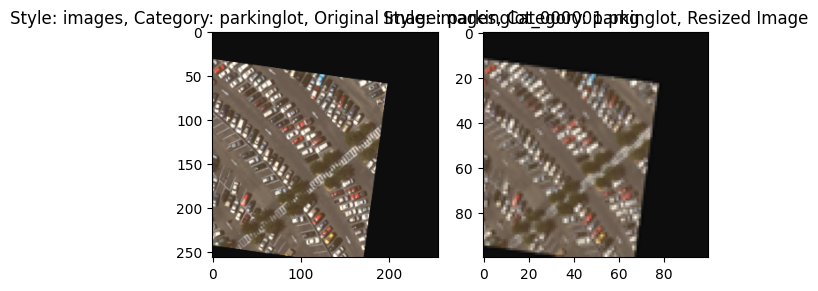

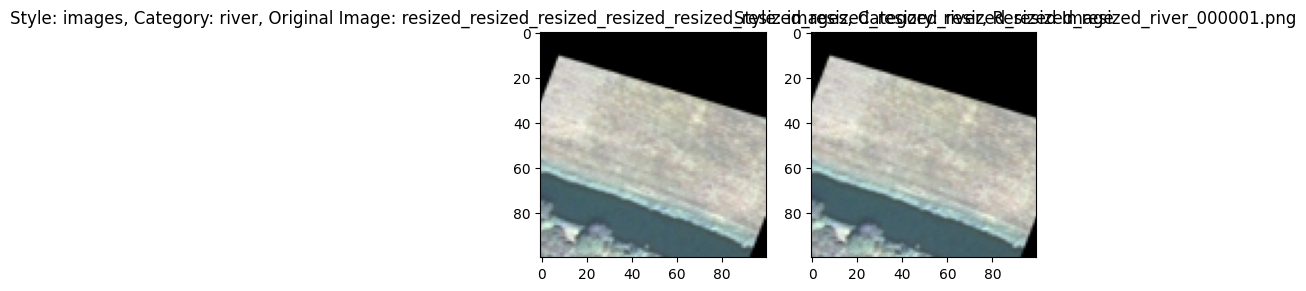

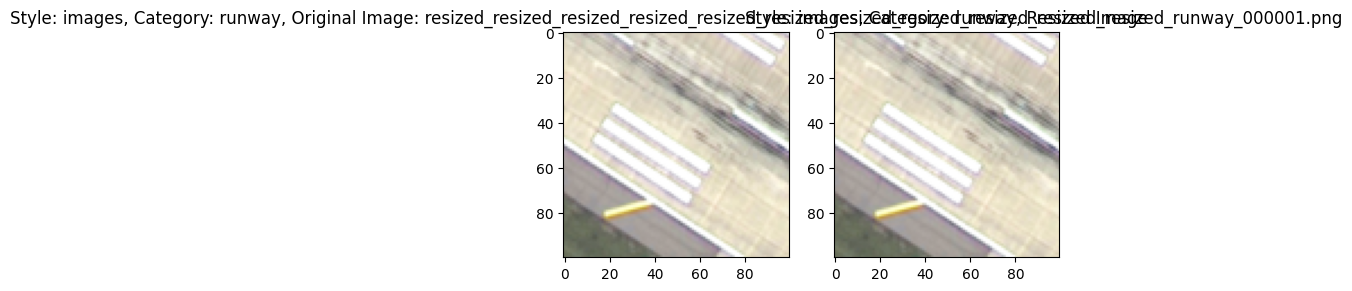

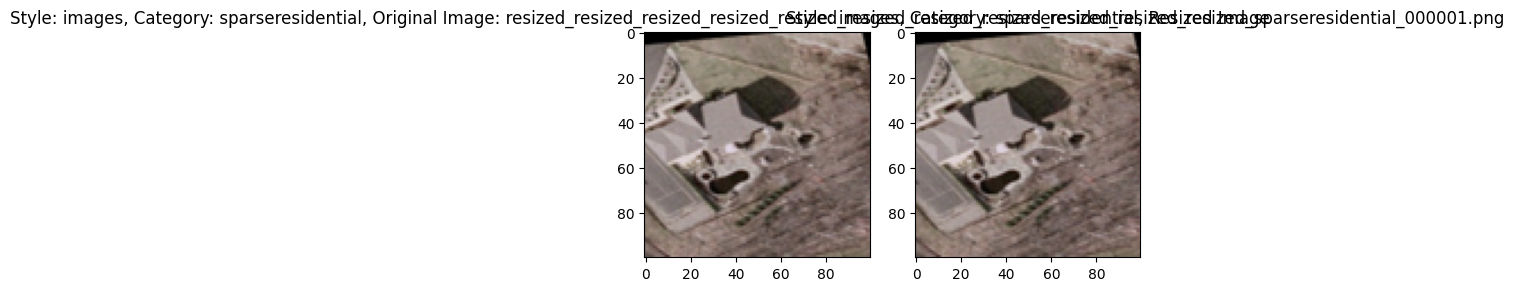

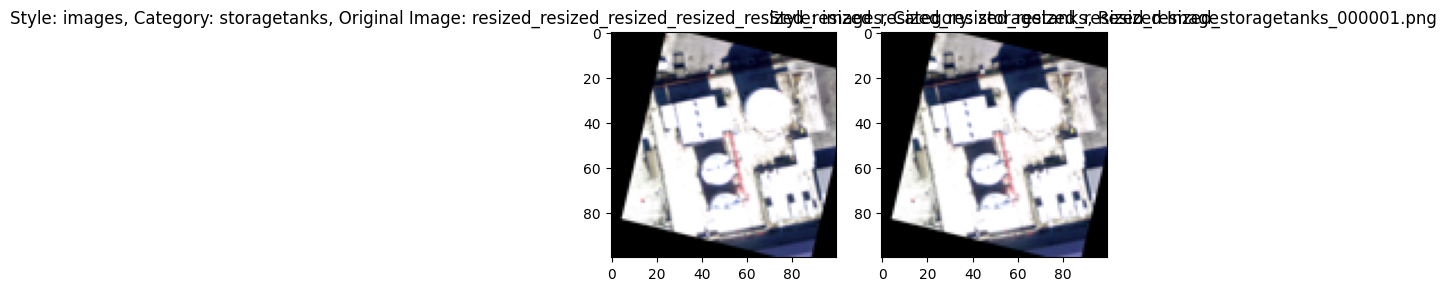

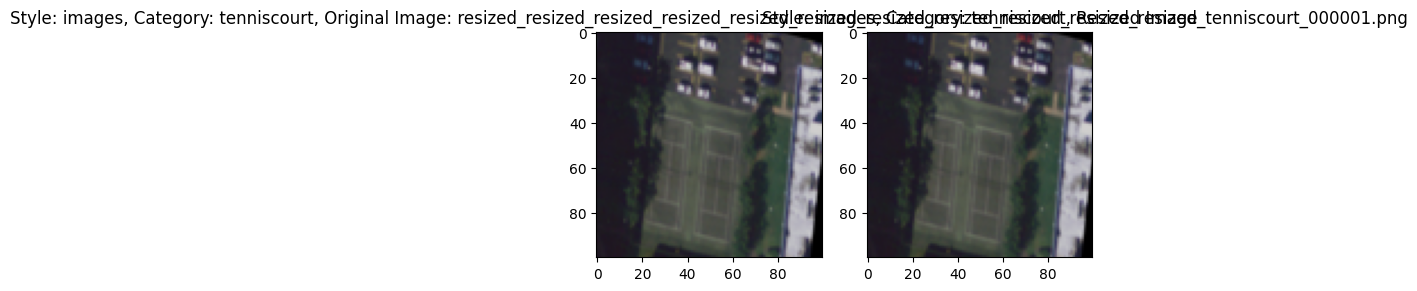

Processing style: images_train_test_val
All categories in images_train_test_val: ['test', 'train', 'validation']
No images found in test category.
No images found in train category.
No images found in validation category.


In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

data_file = 'C:\\Users\\MANJU VARSHENI\\OneDrive\\Desktop\\dataset\\Landuse'

# List all files and directories in the root directory
all_files = os.listdir(data_file)

# Filter directories excluding .ipynb_checkpoints
styles = [style for style in all_files if os.path.isdir(os.path.join(data_file, style)) and style != '.ipynb_checkpoints']

# Display both original and resized images for a representative image in each category
for style in styles:
    print(f"Processing style: {style}")
    style_path = os.path.join(data_file, style)

    # List all categories in the style directory
    categories = [category for category in os.listdir(style_path) if os.path.isdir(os.path.join(style_path, category))]
    print(f"All categories in {style}: {categories}")

    # Display both original and resized images for a representative image in each category
    for category in categories:
        category_path = os.path.join(style_path, category)

        # List all image files in the category directory
        image_files = [image_file for image_file in os.listdir(category_path) if image_file.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Display the first image in the category (if any)
        if image_files:
            # Original image
            original_image_path = os.path.join(category_path, image_files[0])
            original_image = Image.open(original_image_path)

            # Resized image
            resized_image_path = os.path.join(category_path, "resized_" + image_files[0])

            # Resize and save the image if it hasn't been done already
            if not os.path.exists(resized_image_path):
                resized_image = original_image.resize((100, 100))  # Adjust the size as needed
                resized_image.save(resized_image_path)

            # Open the resized image
            resized_image = Image.open(resized_image_path)

            # Display original image
            plt.subplot(1, 2, 1)
            plt.imshow(original_image)
            plt.title(f"Style: {style}, Category: {category}, Original Image: {image_files[0]}")

            # Display resized image
            plt.subplot(1, 2, 2)
            plt.imshow(resized_image)
            plt.title(f"Style: {style}, Category: {category}, Resized Image")

            plt.show()
        else:
            print(f"No images found in {category} category.")

In [3]:
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    
    ax[0].plot(history.history['loss'], label="Training Loss")
    ax[0].plot(history.history['val_loss'], label="Validation Loss")
    ax[1].plot(history.history['accuracy'], label="Training Accuracy")
    ax[1].plot(history.history['val_accuracy'], label="Validation Accuracy")
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    
    plt.show();
    pass

In [4]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.0
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j,i, format(cm[i,j], fmt),
                horizontalalignment = "center",
                color = "white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.grid(None);
    pass

In [5]:
dataset_path = "C:\\Users\\MANJU VARSHENI\\OneDrive\\Desktop\\dataset\\Landuse\\images"

with open("C:\\Users\\MANJU VARSHENI\\OneDrive\\Desktop\\dataset\\Landuse\\label_map.json","r") as file:
    class_name_binarized = json.load(file)

num_classes = len(class_name_binarized)
class_names = list(class_name_binarized.keys())
class_name_binarized

{'agricultural': 0,
 'airplane': 1,
 'baseballdiamond': 2,
 'beach': 3,
 'buildings': 4,
 'chaparral': 5,
 'denseresidential': 6,
 'forest': 7,
 'freeway': 8,
 'golfcourse': 9,
 'intersection': 10,
 'mediumresidential': 11,
 'mobilehomepark': 12,
 'overpass': 13,
 'parkinglot': 14,
 'river': 15,
 'runway': 16,
 'sparseresidential': 17,
 'storagetanks': 18,
 'tenniscourt': 19,
 'harbor': 20}

In [6]:
def load_data(csv_file):
    images, labels = [], []
    
    data = pd.read_csv(csv_file,index_col="Unnamed: 0")
    
    for i in tqdm(range(data.shape[0])):
        
        img_name = data.loc[i,'Filename']
        img = load_img(os.path.join(dataset_path,img_name),target_size=(224,224))
        img = img_to_array(img)
        
        img = preprocess_input(img)
        label = data.loc[i,'Label']
        
        images.append(img)
        labels.append(label)
        pass
    
    images = np.array(images)
    labels = np.array(labels)
    return images, labels
    pass

In [7]:
train_images, train_labels = load_data("C:\\Users\\MANJU VARSHENI\\OneDrive\\Desktop\\dataset\\Landuse\\train.csv")
val_images, val_labels = load_data("C:\\Users\\MANJU VARSHENI\\OneDrive\\Desktop\\dataset\\Landuse\\validation.csv")

train_images.shape, train_labels.shape, val_images.shape, val_labels.shape

100%|█████████████████████████████████████████████████████████████████████████████| 2100/2100 [00:06<00:00, 341.90it/s]


((7350, 224, 224, 3), (7350,), (2100, 224, 224, 3), (2100,))

In [8]:
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)

train_labels.shape, val_labels.shape

((7350, 21), (2100, 21))

In [9]:
def conv_block(X,k,filters,stage,block,s=2):
    
    conv_base_name = 'conv_' + str(stage) + block + '_branch'
    bn_base_name = 'bn_' + str(stage) + block + '_branch'
    ac_base_name = 'ac_' + str(stage) + block + '_branch'
    
    F1 = filters
    
    X = Conv2D(filters=F1, kernel_size=(k,k), strides=(s,s),
              padding='same', name=conv_base_name+'2a')(X)
    X = BatchNormalization(name=bn_base_name+'2a')(X)
    X = Activation("relu", name=ac_base_name+'2a')(X)
    
    return X
    pass

In [10]:
def conv_model(input_shape, classes):
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((5,5),name="zero_padding_1")(X_input)
    
    X = Conv2D(16,(3,3), strides=(2,2), name='conv1', padding="same")(X)
    X = BatchNormalization(name="bn_conv1")(X)
    
    X = conv_block(X,3,32,2,block='A',s=1)
    X = MaxPooling2D((2,2), name="max_pooling_2")(X)
    X = Dropout(0.25, name="dropout_2")(X)
    
    X = conv_block(X,5,32,3,block='A',s=2)
    X = MaxPooling2D((2,2), name="max_pooling_3")(X)
    X = Dropout(0.25, name="dropout_3")(X)
    
    X = conv_block(X,3,64,4,block='A',s=1)
    X = MaxPooling2D((2,2), name="max_pooling_4")(X)
    X = Dropout(0.25, name="dropout_4")(X)
    
    X = Flatten(name="flatten_1")(X)
    X = Dense(64,name="dense_1")(X)
    X = Activation("relu",name="dense_relu_1")(X)
    X = Dense(128,name="dense_2")(X)
    X = Activation("relu", name="dense_relu_2")(X)
    
    X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)
    
    model = Model(inputs=X_input, outputs=X, name="Basic_Conv_model")
    
    return model
    pass

In [11]:
model = conv_model(input_shape=(224,224,3),classes=num_classes)

In [12]:
import tensorflow as tf
tf.compat.v1.executing_eagerly_outside_functions


<function tensorflow.python.framework.ops.executing_eagerly_outside_functions()>

In [13]:
tf.compat.v1.nn.fused_batch_norm

<function tensorflow.python.ops.nn_impl.fused_batch_norm(x, scale, offset, mean=None, variance=None, epsilon=0.001, data_format='NHWC', is_training=True, name=None, exponential_avg_factor=1.0)>

In [14]:
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=['accuracy'])

In [15]:
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
logs = TensorBoard("logs")

In [16]:
epochs = 80
batch_size = 10

history = model.fit(train_images, train_labels,
                   steps_per_epoch=len(train_images)//batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(val_images, val_labels),
                   validation_steps=len(val_images)//batch_size,
                   callbacks=[checkpoint, logs])

Epoch 1/80

735/735 [==============================] - ETA: 0s - loss: 2.6904 - accuracy: 0.1486
Epoch 1: val_accuracy improved from -inf to 0.17810, saving model to model_weights.h5
735/735 [==============================] - 57s 74ms/step - loss: 2.6904 - accuracy: 0.1486 - val_loss: 2.5027 - val_accuracy: 0.1781
Epoch 2/80
  1/735 [..............................] - ETA: 37s - loss: 2.2999 - accuracy: 0.4000

C:\Users\MANJU VARSHENI\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


735/735 [==============================] - ETA: 0s - loss: 2.3261 - accuracy: 0.2536
Epoch 2: val_accuracy improved from 0.17810 to 0.32762, saving model to model_weights.h5
735/735 [==============================] - 48s 66ms/step - loss: 2.3261 - accuracy: 0.2536 - val_loss: 2.0582 - val_accuracy: 0.3276
Epoch 3/80
735/735 [==============================] - ETA: 0s - loss: 2.0234 - accuracy: 0.3298
Epoch 3: val_accuracy did not improve from 0.32762
735/735 [==============================] - 48s 65ms/step - loss: 2.0234 - accuracy: 0.3298 - val_loss: 2.2897 - val_accuracy: 0.2738
Epoch 4/80
735/735 [==============================] - ETA: 0s - loss: 1.8371 - accuracy: 0.3912
Epoch 4: val_accuracy improved from 0.32762 to 0.42762, saving model to model_weights.h5
735/735 [==============================] - 48s 65ms/step - loss: 1.8371 - accuracy: 0.3912 - val_loss: 1.7085 - val_accuracy: 0.4276
Epoch 5/80
735/735 [==============================] - ETA: 0s - loss: 1.7000 - accuracy: 0.4264

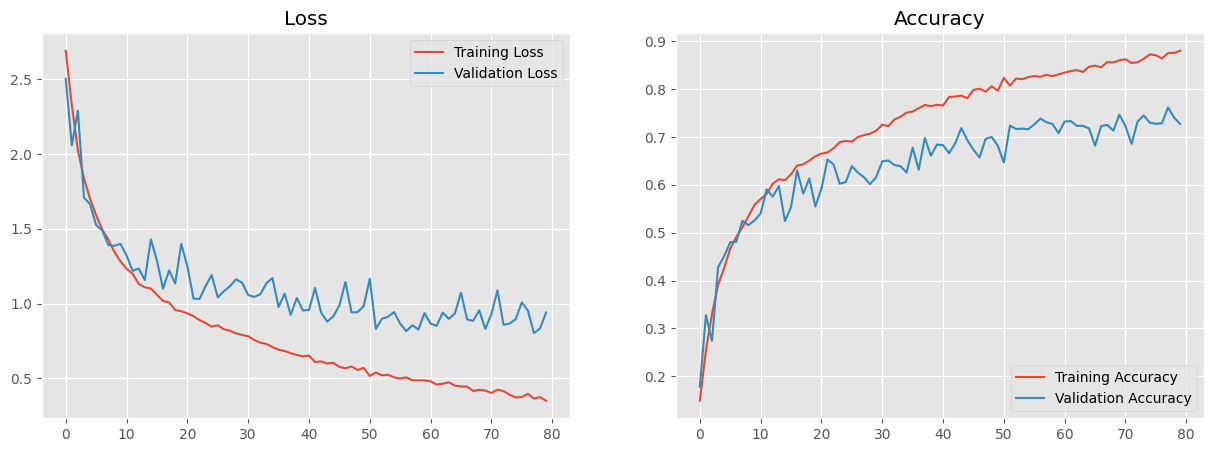

In [17]:
show_final_history(history)

In [18]:
val_pred = model.predict(val_images)
val_pred = np.argmax(val_pred, axis=1)
val_pred.shape

66/66 [==============================] - 5s 66ms/step


(2100,)

<Figure size 640x480 with 0 Axes>

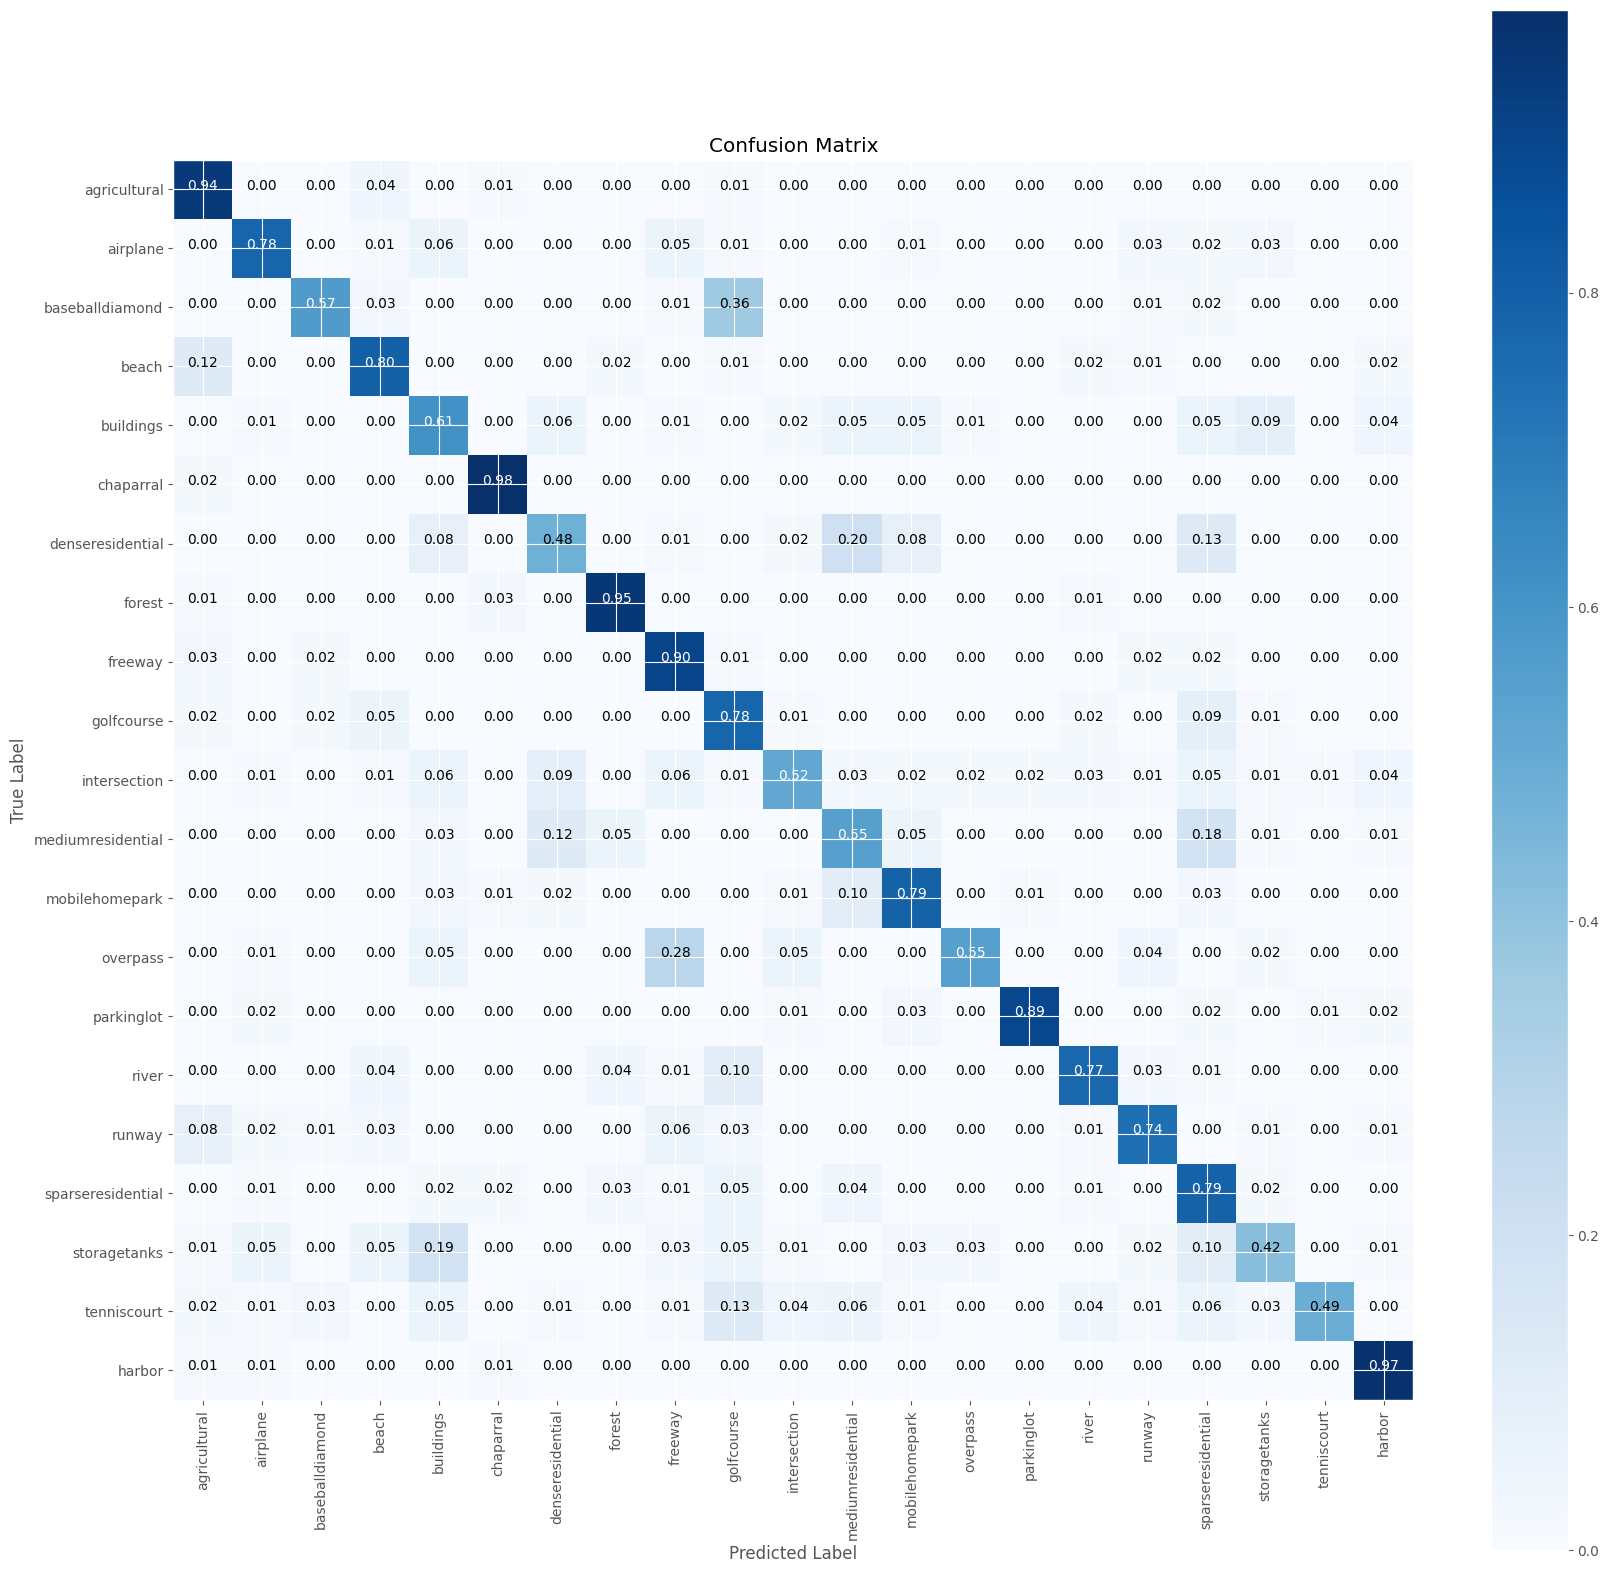

In [20]:
val_actual = np.argmax(val_labels, axis=1)

cnf_mat = confusion_matrix(val_actual, val_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat, classes=class_names)
plt.grid(None)
plt.show();

In [21]:
train_dir = "C:\\Users\\MANJU VARSHENI\\OneDrive\\Desktop\\dataset\\Landuse\\images_train_test_val\\train"
val_dir = "C:\\Users\\MANJU VARSHENI\\OneDrive\\Desktop\\dataset\\Landuse\\images_train_test_val\\validation"

batchSize = 10

IGD = ImageDataGenerator(rescale=1./255.)

train_generator = IGD.flow_from_directory(train_dir,
                                         target_size=(224,224),
                                         color_mode='rgb',
                                         batch_size=batchSize,
                                         class_mode='categorical',
                                         shuffle=True,
                                         seed=42)

val_generator = IGD.flow_from_directory(val_dir,
                                        target_size=(224,224),
                                        color_mode='rgb',
                                        batch_size=batchSize,
                                        class_mode='categorical',
                                        shuffle=True,
                                        seed=42)

Found 7350 images belonging to 21 classes.
Found 2109 images belonging to 21 classes.


In [22]:
Dense(21, activation='softmax')


In [23]:
model = conv_model(input_shape=(224,224,3),classes=num_classes)
model.summary()

Model: "Basic_Conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding_1 (ZeroPaddin  (None, 234, 234, 3)       0         
 g2D)                                                            
                                                                 
 conv1 (Conv2D)              (None, 117, 117, 16)      448       
                                                                 
 bn_conv1 (BatchNormalizati  (None, 117, 117, 16)      64        
 on)                                                             
                                                                 
 conv_2A_branch2a (Conv2D)   (None, 117, 117, 32)      4640      
                                                                 
 bn_2A_branch2a (BatchNorma  (None, 117, 117, 32) 

In [24]:
dataset_path = "C:\\Users\\MANJU VARSHENI\\OneDrive\\Desktop\\dataset\\Landuse\\images"

with open("C:\\Users\\MANJU VARSHENI\\OneDrive\\Desktop\\dataset\\Landuse\\label_map.json","r") as file:
    class_name_binarized = json.load(file)

num_classes = len(class_name_binarized)
class_names = list(class_name_binarized.keys())
print("Number of classes:", num_classes)
print("Class names:", class_names)


Number of classes: 21
Class names: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt', 'harbor']


In [25]:
# Get the last layer of your model
last_layer = model.layers[-1]

# Check the number of units and activation function in the last layer
print(last_layer)


In [26]:
def modified_conv_model(input_shape, classes):
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((5, 5), name="zero_padding_1")(X_input)
    
    X = Conv2D(16, (3, 3), strides=(2, 2), name='conv1', padding="same")(X)
    X = BatchNormalization(name="bn_conv1")(X)
    
    X = conv_block(X, 3, 32, 2, block='A', s=1)
    X = MaxPooling2D((2, 2), name="max_pooling_2")(X)
    X = Dropout(0.25, name="dropout_2")(X)
    
    X = conv_block(X, 5, 32, 3, block='A', s=2)
    X = MaxPooling2D((2, 2), name="max_pooling_3")(X)
    X = Dropout(0.25, name="dropout_3")(X)
    
    X = conv_block(X, 3, 64, 4, block='A', s=1)
    X = MaxPooling2D((2, 2), name="max_pooling_4")(X)
    X = Dropout(0.25, name="dropout_4")(X)
    
    X = Flatten(name="flatten_1")(X)
    X = Dense(64, name="dense_1")(X)
    X = Activation("relu", name="dense_relu_1")(X)
    
    X = Dense(128, name="dense_2")(X)
    X = Activation("relu", name="dense_relu_2")(X)
    
    X = Dense(classes, activation="softmax", name="output_layer")(X)  # Modified last layer
    
    model = Model(inputs=X_input, outputs=X, name="Modified_Conv_model")
    
    return model


In [27]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense

# Assuming you have an Input layer
input_layer = Input(shape=(224, 224, 3))

# Example Convolutional layers
conv1 = Conv2D(16, (3, 3), padding='same')(input_layer)
bn_conv1 = BatchNormalization()(conv1)
activation1 = Activation('relu')(bn_conv1)
# ... Additional convolutional layers ...

# Assuming this is the last layer before flatten
previous_layers_output = activation1

# Flatten layer
x = Flatten()(previous_layers_output)

# New output layer
output_layer = Dense(num_classes, activation='softmax', name='output_layer')(x)

# Create a new model with the modified output layer
model = Model(inputs=input_layer, outputs=output_layer)


66/66 [==============================] - 4s 65ms/step


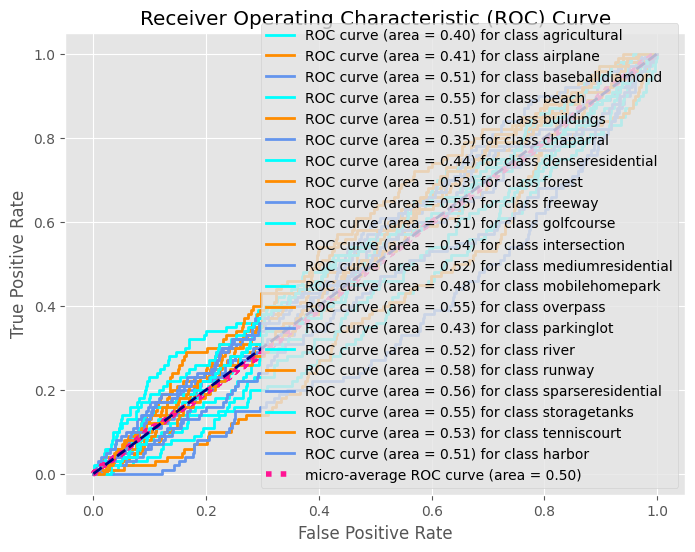

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from itertools import cycle


# Modify the last layer of your model
model_output = Dense(num_classes, activation='softmax', name='output_layer')(model.layers[-2].output)
model = Model(inputs=model.input, outputs=model_output)

# Compile the model with an appropriate optimizer and loss function

# Assuming val_pred_prob is the predicted probabilities and val_labels_binarized are the original one-hot encoded class labels
val_pred_prob = model.predict(val_images)
val_labels_binarized = label_binarize(val_labels, classes=np.arange(num_classes))

# Ensure both arrays have the correct shape
if val_labels_binarized.shape[1] != num_classes or val_pred_prob.shape[1] != num_classes:
    raise ValueError("Number of classes mismatch in val_labels_binarized or val_pred_prob.")

# Initialize variables
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(val_labels_binarized[:, i], val_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(val_labels_binarized.ravel(), val_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], class_names[i]))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4, label='micro-average ROC curve (area = {:.2f})'.format(roc_auc["micro"]))

# Plot random chance
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [29]:
from sklearn.metrics import classification_report

val_pred = model.predict(val_images)
val_pred_classes = np.argmax(val_pred, axis=1)
val_true_classes = np.argmax(val_labels, axis=1)

# Generate classification report
report = classification_report(val_true_classes, val_pred_classes, target_names=class_names)

# Print the report
print(report)


66/66 [==============================] - 4s 64ms/step
                   precision    recall  f1-score   support

     agricultural       0.00      0.00      0.00       100
         airplane       0.01      0.01      0.01       100
  baseballdiamond       0.06      0.15      0.09       100
            beach       0.10      0.05      0.07       100
        buildings       0.00      0.00      0.00       100
        chaparral       0.01      0.03      0.02       100
 denseresidential       0.05      0.04      0.05       100
           forest       0.05      0.13      0.07       100
          freeway       0.20      0.01      0.02       100
       golfcourse       0.00      0.00      0.00       100
     intersection       0.05      0.01      0.02       100
mediumresidential       0.00      0.00      0.00       100
   mobilehomepark       0.06      0.08      0.07       100
         overpass       0.08      0.01      0.02       100
       parkinglot       0.00      0.00      0.00       100
 

66/66 [==============================] - 4s 61ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


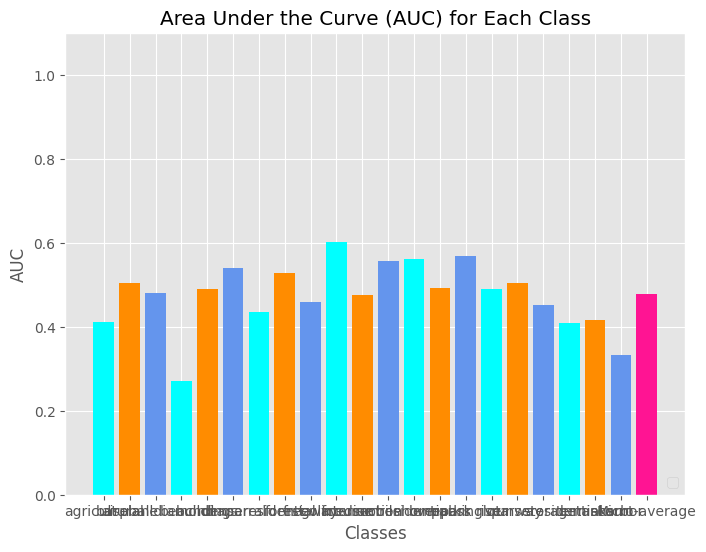

In [30]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from itertools import cycle

# Assuming your model is already trained and you have val_images and val_labels

# Modify the last layer of your model
model_output = Dense(num_classes, activation='softmax', name='output_layer')(model.layers[-2].output)
model = Model(inputs=model.input, outputs=model_output)

# Compile the model with an appropriate optimizer and loss function

# Assuming val_pred_prob is the predicted probabilities and val_labels_binarized are the original one-hot encoded class labels
val_pred_prob = model.predict(val_images)
val_labels_binarized = label_binarize(val_labels, classes=np.arange(num_classes))

# Ensure both arrays have the correct shape
if val_labels_binarized.shape[1] != num_classes or val_pred_prob.shape[1] != num_classes:
    raise ValueError("Number of classes mismatch in val_labels_binarized or val_pred_prob.")

# Initialize variables
roc_auc = dict()

# Compute AUC for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(val_labels_binarized[:, i], val_pred_prob[:, i])
    roc_auc[i] = auc(fpr, tpr)

# Compute micro-average AUC
fpr_micro, tpr_micro, _ = roc_curve(val_labels_binarized.ravel(), val_pred_prob.ravel())
roc_auc['micro'] = auc(fpr_micro, tpr_micro)

# Plot AUC for each class
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.bar(class_names[i], roc_auc[i], color=color)

# Plot micro-average AUC
plt.bar('Micro-average', roc_auc['micro'], color='deeppink')

# Customize the plot
plt.xlabel('Classes')
plt.ylabel('AUC')
plt.title('Area Under the Curve (AUC) for Each Class')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')
plt.show()


In [32]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# Load the image
img_path = "C:\\Users\\MANJU VARSHENI\\OneDrive\\Desktop\\dataset\\pred3.jpg"
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand the dimensions to match the input shape expected by the model
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image for the VGG16 model
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Get the indices of the top-3 predicted classes
top_indices = np.argsort(predictions[0])[::-1][:3]

# Get the class names and scores for the top-3 predictions
for i, idx in enumerate(top_indices):
    class_name = class_names[idx]
    score = predictions[0][idx]
    print(f"{i + 1}: {class_name} ({score:.2f})")


1/1 [==============================] - 0s 20ms/step
1: forest (1.00)
2: storagetanks (0.00)
3: beach (0.00)
